In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline
# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


# Load X_df and Y_df pickled in Feature Engineering

In [2]:
X_df = pd.read_pickle('./data/interim/X_df.pkl')
Y_df = pd.read_pickle('./data/interim/Y_df.pkl')

# X and Y are only columns used in modeling

In [3]:
X = X_df.drop(labels=['G1_Fall_RIT', 'G1_Winter_RIT', 'G1_Spring_RIT',\
                      'Last_G1_RIT_Season', 'Treatments'],axis=1)

In [4]:
X.head()

,StudentID,Last_G1_RIT,nTreatments,Female,HomeLanIsEng,PrimaryLanIsEng,LivingWithBothParents,RacialEthnicGroup_American Indian,RacialEthnicGroup_Asian,RacialEthnicGroup_Black,...,MostAttendedSchool_292,MostAttendedSchool_930,MostAttendedSchool_935,MostAttendedSchool_939,MostAttendedSchool_945,MostAttendedSchool_949,MostAttendedSchool_955,MostAttendedSchool_972,MostAttendedSchool_974,MostAttendedSchool_977
0,3967736,178,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,3381735,173,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3567417,196,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3130417,211,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3670417,192,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# X = X_df[['StudentID','Female','HomeLanIsEng','PrimaryLanIsEng',\
#           'LivingWithBothParents','Last_G1_RIT','nTreatments']].copy()
Y = Y_df[['Score','LevelCode','MetStandard']].copy()

# Cleaning up X and Y
Including:
* Replacing Last_G1_RIT None values with NaN
* Dropping NA's

In [6]:
df = pd.concat([X, Y.reset_index(drop=True)], axis=1)
df.set_index('StudentID',inplace=True)
df['Last_G1_RIT'].replace({None:np.nan},inplace=True)
df.dropna(inplace=True)
print('The next dataframe should have no rows if successful:')
df[df.isnull().any(axis=1)]

The next dataframe should have no rows if successful:


,Last_G1_RIT,nTreatments,Female,HomeLanIsEng,PrimaryLanIsEng,LivingWithBothParents,RacialEthnicGroup_American Indian,RacialEthnicGroup_Asian,RacialEthnicGroup_Black,RacialEthnicGroup_Hispanic,...,MostAttendedSchool_939,MostAttendedSchool_945,MostAttendedSchool_949,MostAttendedSchool_955,MostAttendedSchool_972,MostAttendedSchool_974,MostAttendedSchool_977,Score,LevelCode,MetStandard
StudentID,,,,,,,,,,,,,,,,,,,,,


# Extracting Cleaned X and Y

In [7]:
X = df.iloc[:,:-3]
Y = df[['MetStandard']]

# Train-Test split data:
I'll split off test data and then create a CV data set.

In [8]:
X_tr, X_te, Y_tr, Y_te = train_test_split(X, Y, test_size=0.2, random_state=42)
x_train, x_cv, y_train, y_cv = train_test_split(X_tr,Y_tr, test_size=0.2, random_state=42)

# Fit Logistic Regression Model

In [9]:
logR = LogisticRegression(C=.5,solver='lbfgs',verbose=True,max_iter=1000)
logR.fit(x_train, y_train.MetStandard.ravel())
y_cv_pred = logR.predict(x_cv)
f1_score(y_cv_pred, y_cv.MetStandard.ravel(),pos_label='Y')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


0.8748451053283767

In [10]:
print(classification_report(y_cv,y_cv_pred))

              precision    recall  f1-score   support

           N       0.70      0.69      0.69       167
           Y       0.87      0.88      0.87       402

    accuracy                           0.82       569
   macro avg       0.79      0.78      0.78       569
weighted avg       0.82      0.82      0.82       569



# Fit Logistic Regression with Cross Validation Model

In [11]:
logRcv = LogisticRegressionCV(Cs=500,scoring="f1",cv=5,max_iter=1000)
logRcv.fit(X_tr, Y_tr.MetStandard.ravel())
y_cv_pred = logRcv.predict(x_cv)
f1_score(y_cv_pred, y_cv.MetStandard.ravel(),pos_label='Y')

0.8875154511742892

In [12]:
logRcv.C_

array([0.56429085])

In [13]:
print(classification_report(y_cv,y_cv_pred))

              precision    recall  f1-score   support

           N       0.73      0.71      0.72       167
           Y       0.88      0.89      0.89       402

    accuracy                           0.84       569
   macro avg       0.81      0.80      0.81       569
weighted avg       0.84      0.84      0.84       569



# Coefficient Plots

In [14]:
logRcoef = pd.DataFrame({'feature':X.columns,'coefficient':logR.coef_[0]})
logRcvcoef = pd.DataFrame({'feature':X.columns,'coefficient':logRcv.coef_[0]})
#coef.head(13)

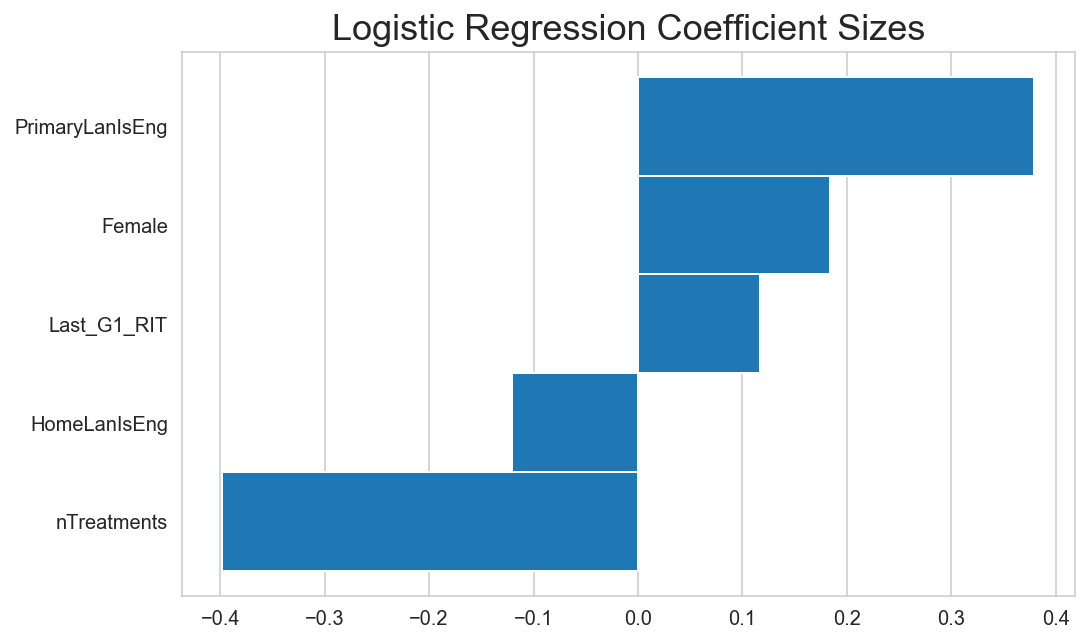

In [15]:
logRcoef = pd.DataFrame({'feature':X.columns,'coefficient':logR.coef_[0]})
Coefs = logRcoef.iloc[0:5,:].sort_values(by=['coefficient'])#,ascending=False)
ax = Coefs.plot.barh(figsize=(8,5),width=1,legend=False)#,color='black')
ax.set_yticklabels(Coefs.feature)
ax.yaxis.grid(False)
#ax.set_ylabel('Ethnic Group', fontsize=18)
fig = ax.get_figure()
ax.set_title('Logistic Regression Coefficient Sizes', fontsize=18)
fig.savefig('./reports/figures/logRCoefficients1.svg', format='svg', dpi=1200)
ax;

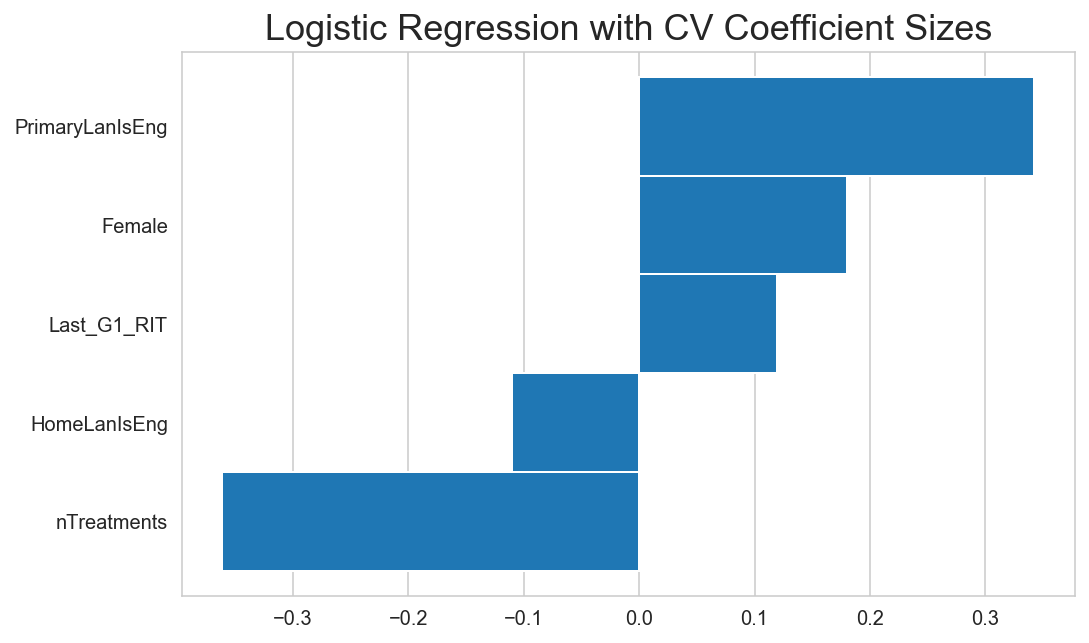

In [16]:
logRcvcoef = pd.DataFrame({'feature':X.columns,'coefficient':logRcv.coef_[0]})
Coefs = logRcvcoef.iloc[0:5,:].sort_values(by=['coefficient'])#,ascending=False)
ax = Coefs.plot.barh(figsize=(8,5),width=1,legend=False)#,color='black')
ax.set_yticklabels(Coefs.feature)
ax.yaxis.grid(False)
fig = ax.get_figure()
ax.set_title('Logistic Regression with CV Coefficient Sizes', fontsize=18)
fig.savefig('./reports/figures/logRcvCoefficients1.svg', format='svg', dpi=1200)
ax;

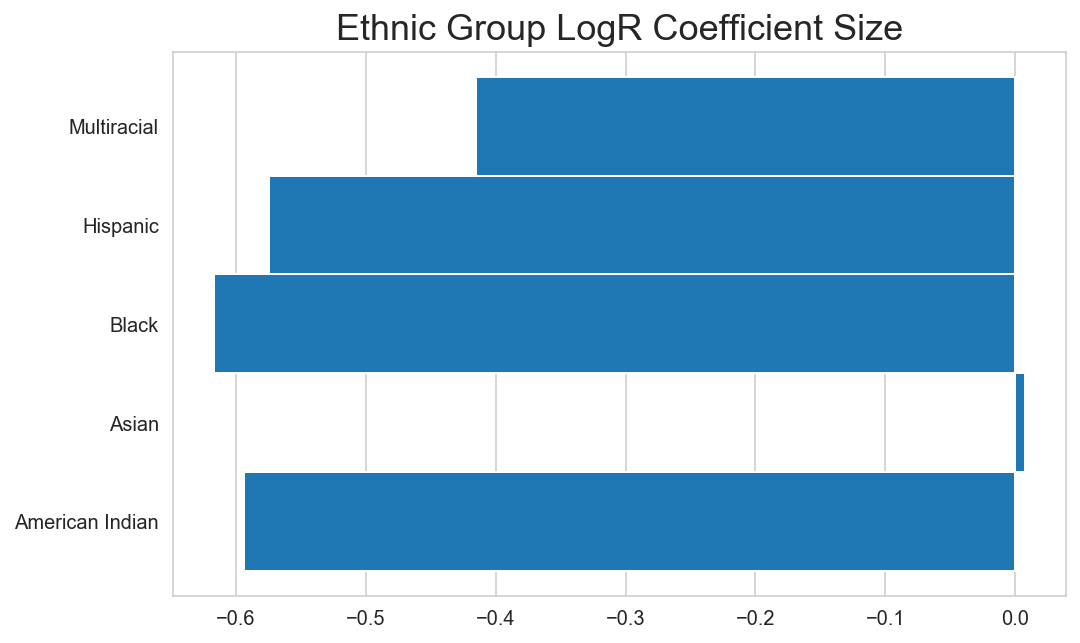

In [17]:
logRcoef = pd.DataFrame({'feature':X.columns,'coefficient':logR.coef_[0]})
ethnicgroups = logRcoef.iloc[6:11,:] #.sort_values(by=['coefficient'],ascending=False)
ax = ethnicgroups.plot.barh(figsize=(8,5),width=1,legend=False)#,color='black')
ax.set_yticklabels(ethnicgroups.feature.str[18:])
ax.yaxis.grid(False)
fig = ax.get_figure()
ax.set_title('Ethnic Group LogR Coefficient Size', fontsize=18)
fig.savefig('./reports/figures/LogREthnicGroupCoeffients.svg', format='svg', dpi=1200)
ax;

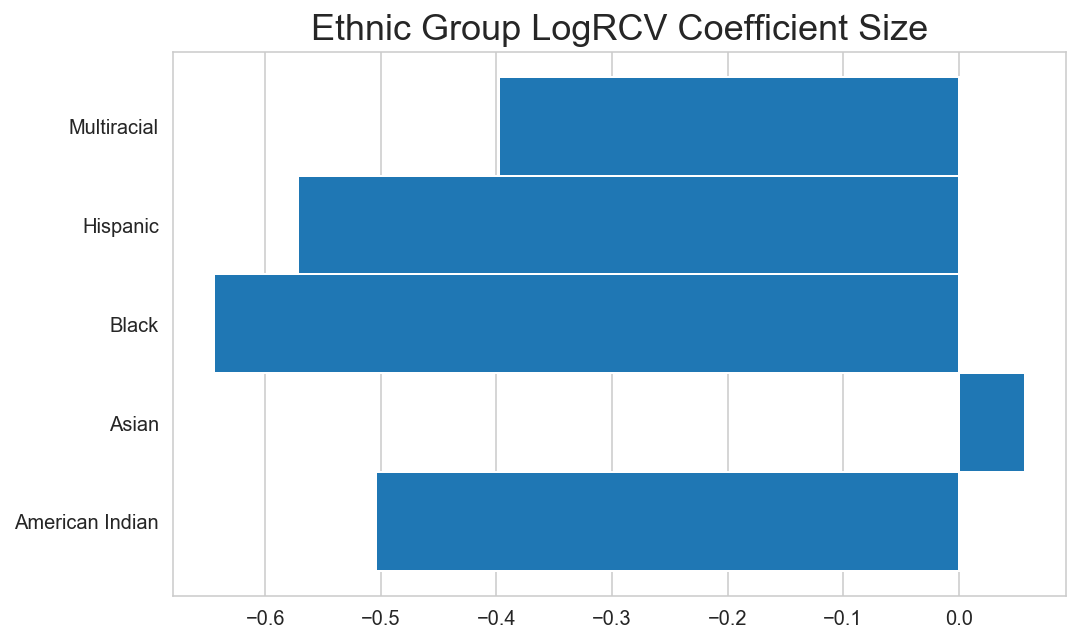

In [18]:
logRcvcoef = pd.DataFrame({'feature':X.columns,'coefficient':logRcv.coef_[0]})
ethnicgroups = logRcvcoef.iloc[6:11,:] #.sort_values(by=['coefficient'],ascending=False)
ax = ethnicgroups.plot.barh(figsize=(8,5),width=1,legend=False)#,color='black')
ax.set_yticklabels(ethnicgroups.feature.str[18:])
ax.yaxis.grid(False)
fig = ax.get_figure()
ax.set_title('Ethnic Group LogRCV Coefficient Size', fontsize=18)
fig.savefig('./reports/figures/LogRcvEthnicGroupCoeffients.svg', format='svg', dpi=1200)
ax;

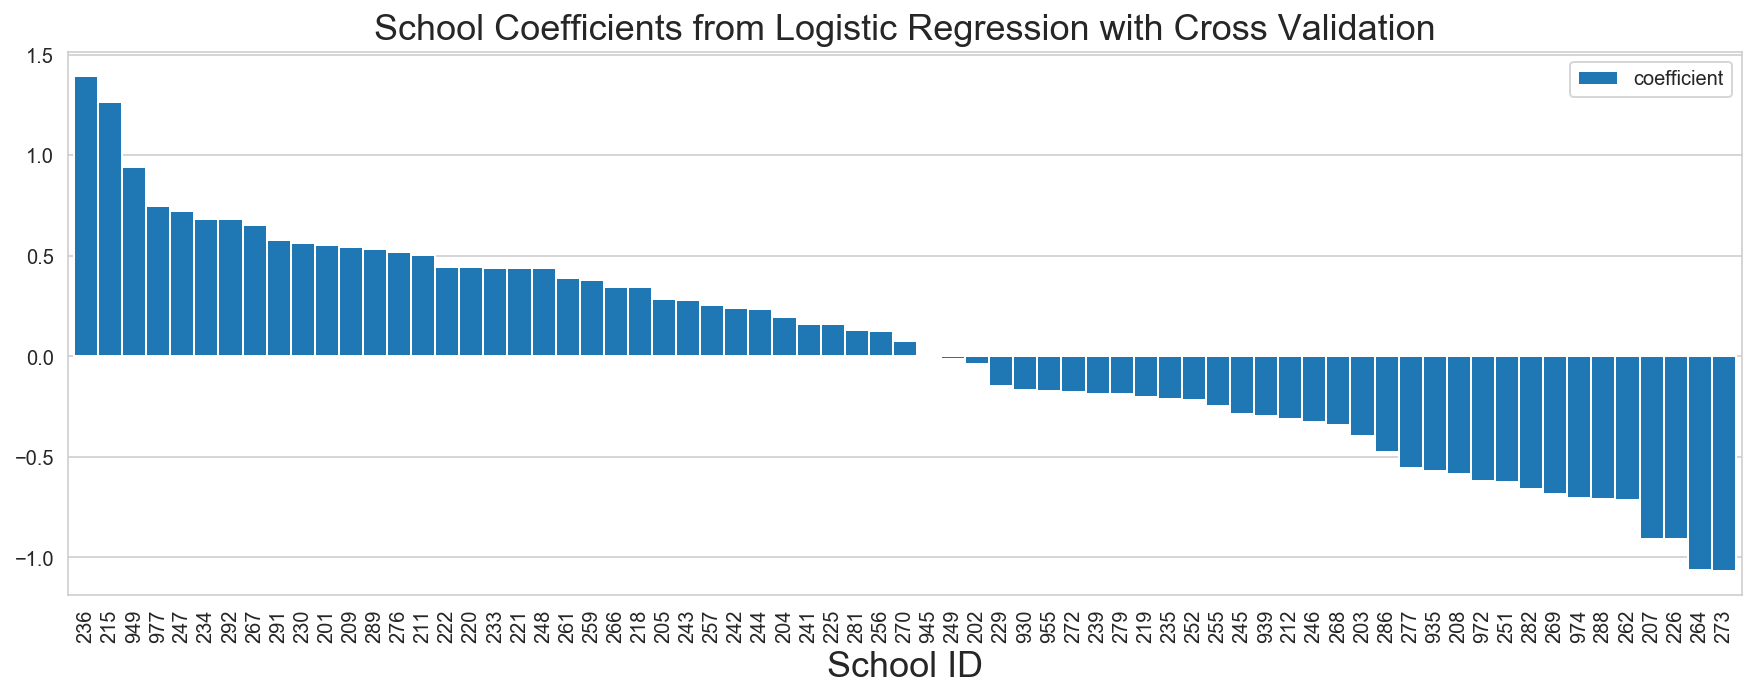

In [19]:
logRcvcoef = pd.DataFrame({'feature':X.columns,'coefficient':logRcv.coef_[0]})
school_coefs = logRcvcoef.iloc[12:,:].sort_values(by=['coefficient'],ascending=False)
ax = school_coefs.plot.bar(figsize=(15,5),width=1,)#color='black')
ax.set_xticklabels(school_coefs.feature.str[-3:])
ax.xaxis.grid(False)
ax.set_xlabel('School ID', fontsize=18)
ax.set_title('School Coefficients from Logistic Regression with Cross Validation', fontsize=18)
fig = ax.get_figure()
fig.savefig('./reports/figures/SchoolCoeffients.svg', format='svg', dpi=1200)
ax;

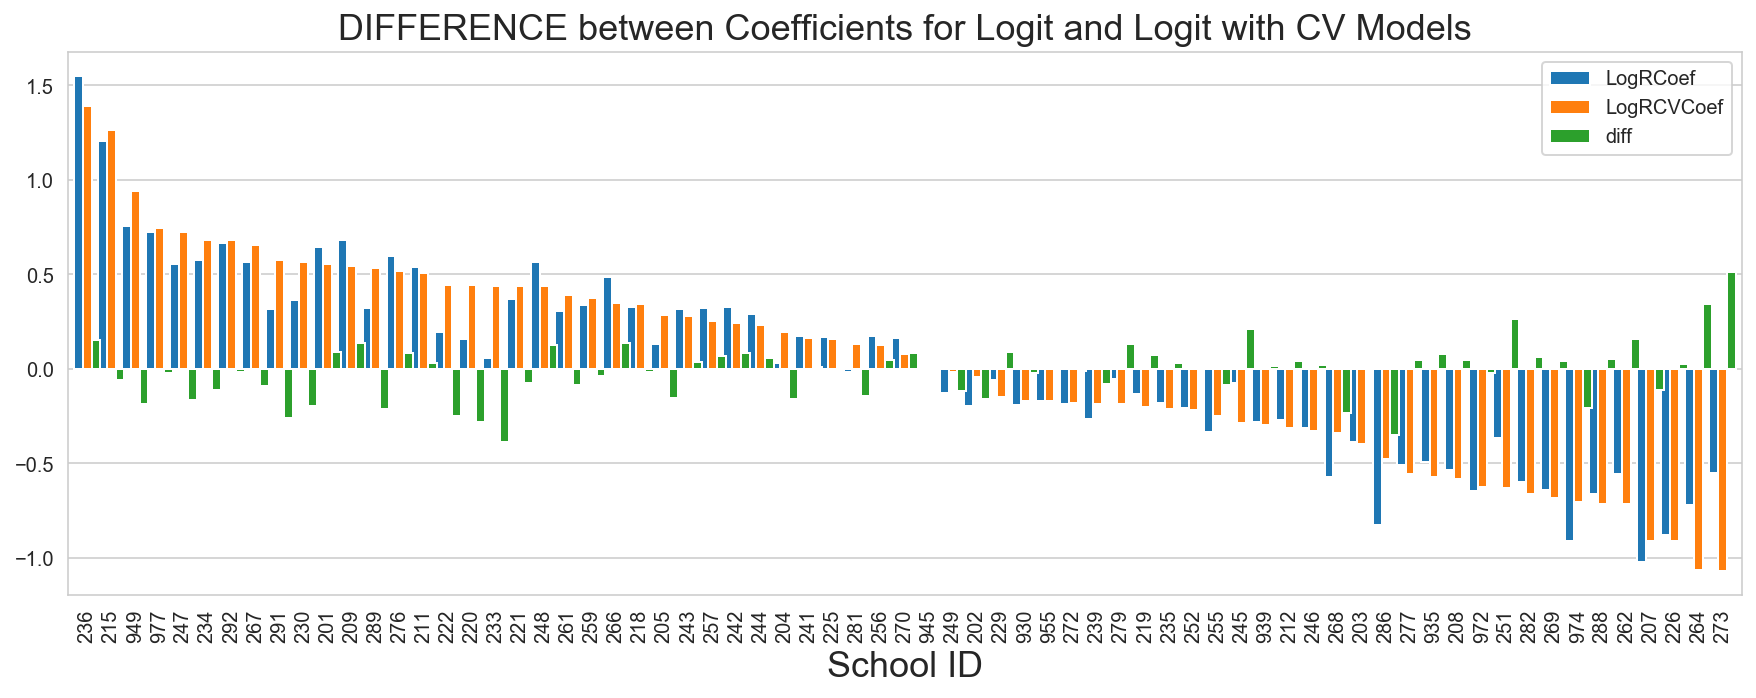

In [20]:
logRcoef = pd.DataFrame({'feature':X.columns,'coefficient':logR.coef_[0]})
logRcvcoef = pd.DataFrame({'feature':X.columns,'coefficient':logRcv.coef_[0]})
# [pd.DataFrame([i], columns=['A']) for i in range(5)],
# ...           ignore_index=True
diffs=pd.concat([logRcoef,logRcvcoef.coefficient],axis=1)
diffs.columns=['feature','LogRCoef','LogRCVCoef']
diffs['diff'] = diffs.LogRCoef - diffs.LogRCVCoef
school_coefs_diffs = diffs.iloc[12:,:].sort_values(by=['LogRCVCoef'],ascending=False)
#df = school_coefs_diffs[['feature','diff']]
ax = school_coefs_diffs.plot.bar(figsize=(15,5),width=1.1,)#color='black')
ax.set_xticklabels(school_coefs_diffs.feature.str[-3:])
ax.xaxis.grid(False)
ax.set_xlabel('School ID', fontsize=18)
ax.set_title('DIFFERENCE between Coefficients for Logit and Logit with CV Models', fontsize=18)
fig = ax.get_figure()
fig.savefig('./reports/figures/SchoolCoeffientsCompare.svg', format='svg', dpi=1200)
ax;

In [21]:
school_coefs_diffs

,feature,LogRCoef,LogRCVCoef,diff
35,MostAttendedSchool_236,1.547494,1.392437,0.155057
22,MostAttendedSchool_215,1.205927,1.264699,-0.058772
76,MostAttendedSchool_949,0.758268,0.943597,-0.185329
80,MostAttendedSchool_977,0.723750,0.747093,-0.023343
43,MostAttendedSchool_247,0.557442,0.723697,-0.166255
...,...,...,...,...
53,MostAttendedSchool_262,-0.555559,-0.714499,0.158940
17,MostAttendedSchool_207,-1.020709,-0.908567,-0.112142
29,MostAttendedSchool_226,-0.880695,-0.909202,0.028507
54,MostAttendedSchool_264,-0.721336,-1.065091,0.343755


# Final evaluation of final models on the test set:

In [22]:
# LogisticRegressionCV
Y_te_pred = logRcv.predict(X_te)
f1_score(Y_te_pred, Y_te.MetStandard.ravel(),pos_label='Y')

0.8842315369261478

In [23]:
print(classification_report(Y_te,Y_te_pred))

              precision    recall  f1-score   support

           N       0.76      0.69      0.72       219
           Y       0.87      0.90      0.88       492

    accuracy                           0.84       711
   macro avg       0.81      0.80      0.80       711
weighted avg       0.83      0.84      0.83       711



# Confusion Matrix
Source of code: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
dt = np.dtype('U10')

Confusion matrix, without normalization
[[152  67]
 [ 49 443]]


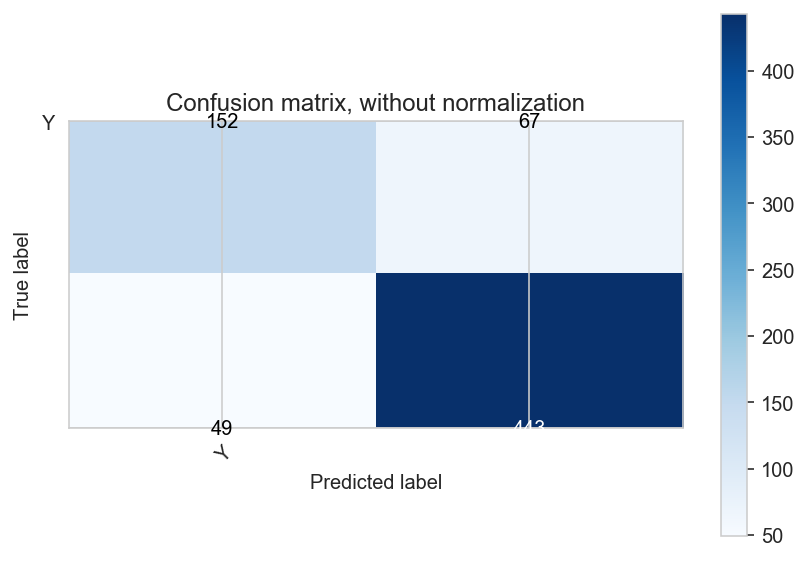

In [25]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig('./reports/figures/ConfusionMatrix.svg', format='svg', dpi=1200)
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = array(['N','Y'], dtype='<U10')
y_test=np.array([row=='Y' for row in Y_te.MetStandard])
y_pred=np.array([row=='Y' for row in Y_te_pred])
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization');